In [65]:
import sys 
import time
import pandas as pd
import numpy as np
import re
import random
from itertools import combinations
import pcalg
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from clustering.sbd import sbd
import matplotlib.pyplot as plt
from citest.fisher_z import ci_test_fisher_z
from statsmodels.tsa.stattools import adfuller

## Parameters ###################################################
#DATA_FILE = "../data/20200826_user-db_network-latency_01.json"
DATA_FILE = "../data/20200826_orders_network-latency_02.json"
TARGET_DATA = {"containers": "all",
               "services": ["throughput", "latency"],
               "nodes": ["node_cpu_seconds_total", "node_disk_io_now", "node_filesystem_avail_bytes", "node_memory_MemAvailable_bytes", "node_network_receive_bytes_total", "node_network_transmit_bytes_total"],
              }#"middlewares": "all"}
PLOTS_NUM = 230
SIGNIFICANCE_LEVEL = 0.01
THRESHOLD_CV = 0.001
THRESHOLD_DIST = 0.001
#################################################################

# Prepare data matrix
raw_data = pd.read_json(DATA_FILE)
#raw_data.head()
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target] or TARGET_DATA[target] == "all":
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1]) if target != "middlewares" else "container_name"].replace("gke-microservices-experi-default-pool-", "")
                if re.match("^gke-microservices-experi", target_name):
                    continue
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                #
                if target_name == "nsenter" :
                    continue
                #print(column_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
                #
data_df = data_df.round(4)
labels = {}
for i in range(len(data_df.columns)):
    labels[i] = data_df.columns[i]

containers_list = []
services_list = []
nodes_list = []
for v in labels.values():
    if re.match("^c-", v):
        container_name = v.split("_")[0].replace("c-", "")
        #
        if container_name == "nsenter" :
            continue
        #
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", v):
        service_name = v.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
    elif re.match("^n-", v):
        node_name = v.split("_")[0].replace("n-", "")
        if node_name not in nodes_list:
            nodes_list.append(node_name)
print("Initial node number: {}".format(len(data_df.columns)))

# Reduce metrics ########################################
reduced_df = pd.DataFrame()
metrics_dimension = {}
clustering_info = {}
# Reduce metrics of container and middleware
for con in containers_list:
    con_df = data_df.loc[:, data_df.columns.str.startswith(("c-{}_".format(con), "m-{}_".format(con)))]
    metrics_dimension[con] = [len(con_df.columns)]
    # Reduce by CV
    n_metrics = 0
    for col in con_df.columns:
        data = data_df[col].values
        #if data.sum() == 0. or np.isnan(data.sum()):
        #    p_val = np.nan
        #else:
        #    p_val = adfuller(data)[1]
        #if np.isnan(p_val) or p_val <= 0.05:
        #    con_df = con_df.drop(col, axis=1)
        #else:
        #    n_metrics += 1
        #    reduced_df[col] = data_df[col]
        mean = data.mean()
        std = data.std()
        if mean == 0. and std == 0.:
            cv = 0
        else:
            cv = std / mean
        if cv >= THRESHOLD_CV:
            n_metrics += 1
            reduced_df[col] = data_df[col]
        else:
            con_df = con_df.drop(col, axis=1)
    metrics_dimension[con].append(n_metrics)
    # Reduce by clustering
    series = con_df.values.T
    dist = pdist(series, metric=sbd)
    dist_matrix = squareform(dist)
    z = linkage(dist, method="single", metric=sbd)
    labels = fcluster(z, t=THRESHOLD_DIST, criterion="distance")
    metrics_dimension[con].append(labels.max())
    cluster_dict = {}
    for i, v in enumerate(labels):
        if v not in cluster_dict:
            cluster_dict[v] = [i]
        else:
            cluster_dict[v].append(i)
    remove_list = []
    for c in cluster_dict:
        cluster_metrics = cluster_dict[c]
        if len(cluster_metrics) == 2:
            # Select the representative metric at random
            shuffle_list = random.sample(cluster_metrics, len(cluster_metrics))
            clustering_info[con_df.columns[shuffle_list[0]]] = [con_df.columns[shuffle_list[1]]]
            remove_list.append(con_df.columns[shuffle_list[1]])
        elif len(cluster_metrics) > 2:
            # Select medoid as the representative metric
            distances = []
            for met1 in cluster_metrics:
                dist_sum = 0
                for met2 in cluster_metrics:
                    if met1 != met2:
                        dist_sum += dist_matrix[met1][met2]
                distances.append(dist_sum)
            medoid = cluster_metrics[np.argmin(distances)]
            clustering_info[con_df.columns[medoid]] = []
            for r in cluster_metrics:
                if r != medoid:
                    remove_list.append(con_df.columns[r])
                    clustering_info[con_df.columns[medoid]].append(con_df.columns[r])                 
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)

# Reduce metrics of services and nodes only by CV
s_n_df = data_df.loc[:, data_df.columns.str.startswith(("s-", "n-"))]
for col in s_n_df.columns:
        data = data_df[col].values
        mean = data.mean()
        std = data.std()
        if mean == 0. and std == 0.:
            cv = 0
        else:
            cv = std / mean
        if cv >= THRESHOLD_CV:
            reduced_df[col] = data_df[col]
            
print("Reduced node number: {}".format(len(reduced_df.columns)))

total_before = 0
total_cv = 0
total_clustering = 0
for con in metrics_dimension:
    total_before += metrics_dimension[con][0]
    total_cv += metrics_dimension[con][1]
    total_clustering += metrics_dimension[con][2]
metrics_dimension["total"] = [total_before, total_cv, total_clustering]
print(metrics_dimension)

labels = {}
for i in range(len(reduced_df.columns)):
    labels[i] = reduced_df.columns[i]

containers_metrics = {}
for c in containers_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^c-{}_".format(c), v):
            nodes.append(k)
    containers_metrics[c] = nodes

services_metrics = {}
for s in services_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^s-{}_".format(s), v):
            nodes.append(k)
    services_metrics[s] = nodes

nodes_metrics = {}
for n in nodes_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^n-{}_".format(n), v):
            nodes.append(k)
    nodes_metrics[n] = nodes
    
## Prior Knowledge ########################################
# Communicating dependency
com_deps = {
    "front-end": ["orders", "carts", "user", "catalogue"],
    "catalogue": ["front-end", "catalogue-db"],
    "catalogue-db": ["catalogue"],
    "orders": ["front-end", "orders-db", "carts", "user", "payement", "shipping"],
    "orders-db": ["orders"],
    "user": ["front-end", "user-db", "orders"],
    "user-db": ["user"],
    "payment": ["orders"],
    "shipping": ["orders", "rabbitmq"],
    "queue-master": ["rabbitmq"],
    "rabbitmq": ["shipping", "queue-master"],
    "carts": ["front-end", "carts-db", "orders"],
    "carts-db": ["carts"],
    "session-db": ["front-end"]
}

# Service-containers relations
service_containers = {
    "carts": ["carts", "carts-db"],
    "payment": ["payment"],
    "shipping": ["shipping"],
    "front-end": ["front-end"],
    "user": ["user", "user-db"],
    "catalogue": ["catalogue", "catalogue-db"],
    "orders": ["orders", "orders-db"]
}

# Share host
nodes_containers = {}
for node, containers in raw_data["mappings"].dropna()["nodes-containers"].items():
    for container in containers:
        #
        if container == "nsenter":
            continue
        #
        nodes_containers[container] = node.replace("gke-microservices-experi-default-pool-", "")
print(nodes_containers)

# C-C
no_paths = []
no_deps_C_C_pair = []
for i, j in combinations(containers_list, 2):
    if j not in com_deps[i] and nodes_containers[i] != nodes_containers[j]:
        no_deps_C_C_pair.append([i, j])
for pair in no_deps_C_C_pair:
    for i in containers_metrics[pair[0]]:
        for j in containers_metrics[pair[1]]:
            no_paths.append([i, j])
print("No dependence C-C pairs: {}, No paths: {}".format(len(no_deps_C_C_pair), len(no_paths)))

# S-S
no_deps_S_S_pair = []
for i, j in combinations(services_list, 2):
    has_comm = False
    for c1 in service_containers[i]:
        for c2 in service_containers[j]:
            if c2 in com_deps[c1]:
                has_comm = True
    if not has_comm:
        no_deps_S_S_pair.append([i, j])
for pair in no_deps_S_S_pair:
    for i in services_metrics[pair[0]]:
        for j in services_metrics[pair[1]]:
            no_paths.append([i, j])
print("No dependence S-S pairs: {}, No paths: {}".format(len(no_deps_S_S_pair), len(no_paths)))

# N-N
no_deps_N_N_pair = []
for i, j in combinations(nodes_list, 2):
    no_deps_N_N_pair.append([i, j])
    for n1 in nodes_metrics[i]:
        for n2 in nodes_metrics[j]:
            no_paths.append([n1, n2])
print("No dependence N-N pairs: {}, No paths: {}".format(len(no_deps_N_N_pair), len(no_paths)))

# C-N
for node in nodes_list:
    for con, host_node in nodes_containers.items():
        if node != host_node:
            for n1 in nodes_metrics[node]:
                for c2 in containers_metrics[con]:
                    no_paths.append([n1, c2])
print("[C-N] No paths: {}".format(len(no_paths)))

# S-N
for service in service_containers:
    host_list = []
    for con in service_containers[service]:
        if nodes_containers[con] not in host_list:
            host_list.append(nodes_containers[con])
    for node in nodes_list:
        if node not in host_list:
            for s1 in services_metrics[service]:
                for n2 in nodes_metrics[node]:
                    no_paths.append([s1, n2])
print("[S-N] No paths: {}".format(len(no_paths)))

# C-S
for service in service_containers:
    for con in containers_metrics:
        if con not in service_containers[service]:
            for s1 in services_metrics[service]:
                for c2 in containers_metrics[con]:
                    no_paths.append([s1, c2])
print("[C-S] No paths: {}".format(len(no_paths)))

Initial node number: 792
Reduced node number: 114
{'orders': [55, 18, 7], 'payment': [53, 13, 7], 'queue-master': [55, 10, 5], 'user': [55, 15, 7], 'carts': [55, 13, 7], 'catalogue-db': [51, 9, 5], 'orders-db': [55, 16, 9], 'rabbitmq': [51, 9, 5], 'catalogue': [55, 11, 5], 'front-end': [55, 15, 6], 'carts-db': [55, 20, 10], 'session-db': [49, 4, 1], 'shipping': [55, 10, 5], 'user-db': [55, 16, 8], 'total': [754, 179, 87]}
{'orders': '66a015a7-eq47', 'queue-master': '66a015a7-eq47', 'user': '66a015a7-eq47', 'payment': '66a015a7-eq47', 'carts': '66a015a7-g7qj', 'rabbitmq': '66a015a7-g7qj', 'orders-db': '66a015a7-g7qj', 'catalogue-db': '66a015a7-g7qj', 'front-end': '66a015a7-i5rl', 'catalogue': '66a015a7-i5rl', 'shipping': '66a015a7-w0i8', 'user-db': '66a015a7-w0i8', 'carts-db': '66a015a7-w0i8', 'session-db': '66a015a7-w0i8'}
No dependence C-C pairs: 61, No paths: 2286
No dependence S-S pairs: 14, No paths: 2342
No dependence N-N pairs: 6, No paths: 2405
[C-N] No paths: 3264
[S-N] No path

Shape of data matrix: (230, 114)
Number of edges in complete graph : 6441
Number of edges in init graph : 1999
Elapsed time:1.234/sec
Number of nodes: 23


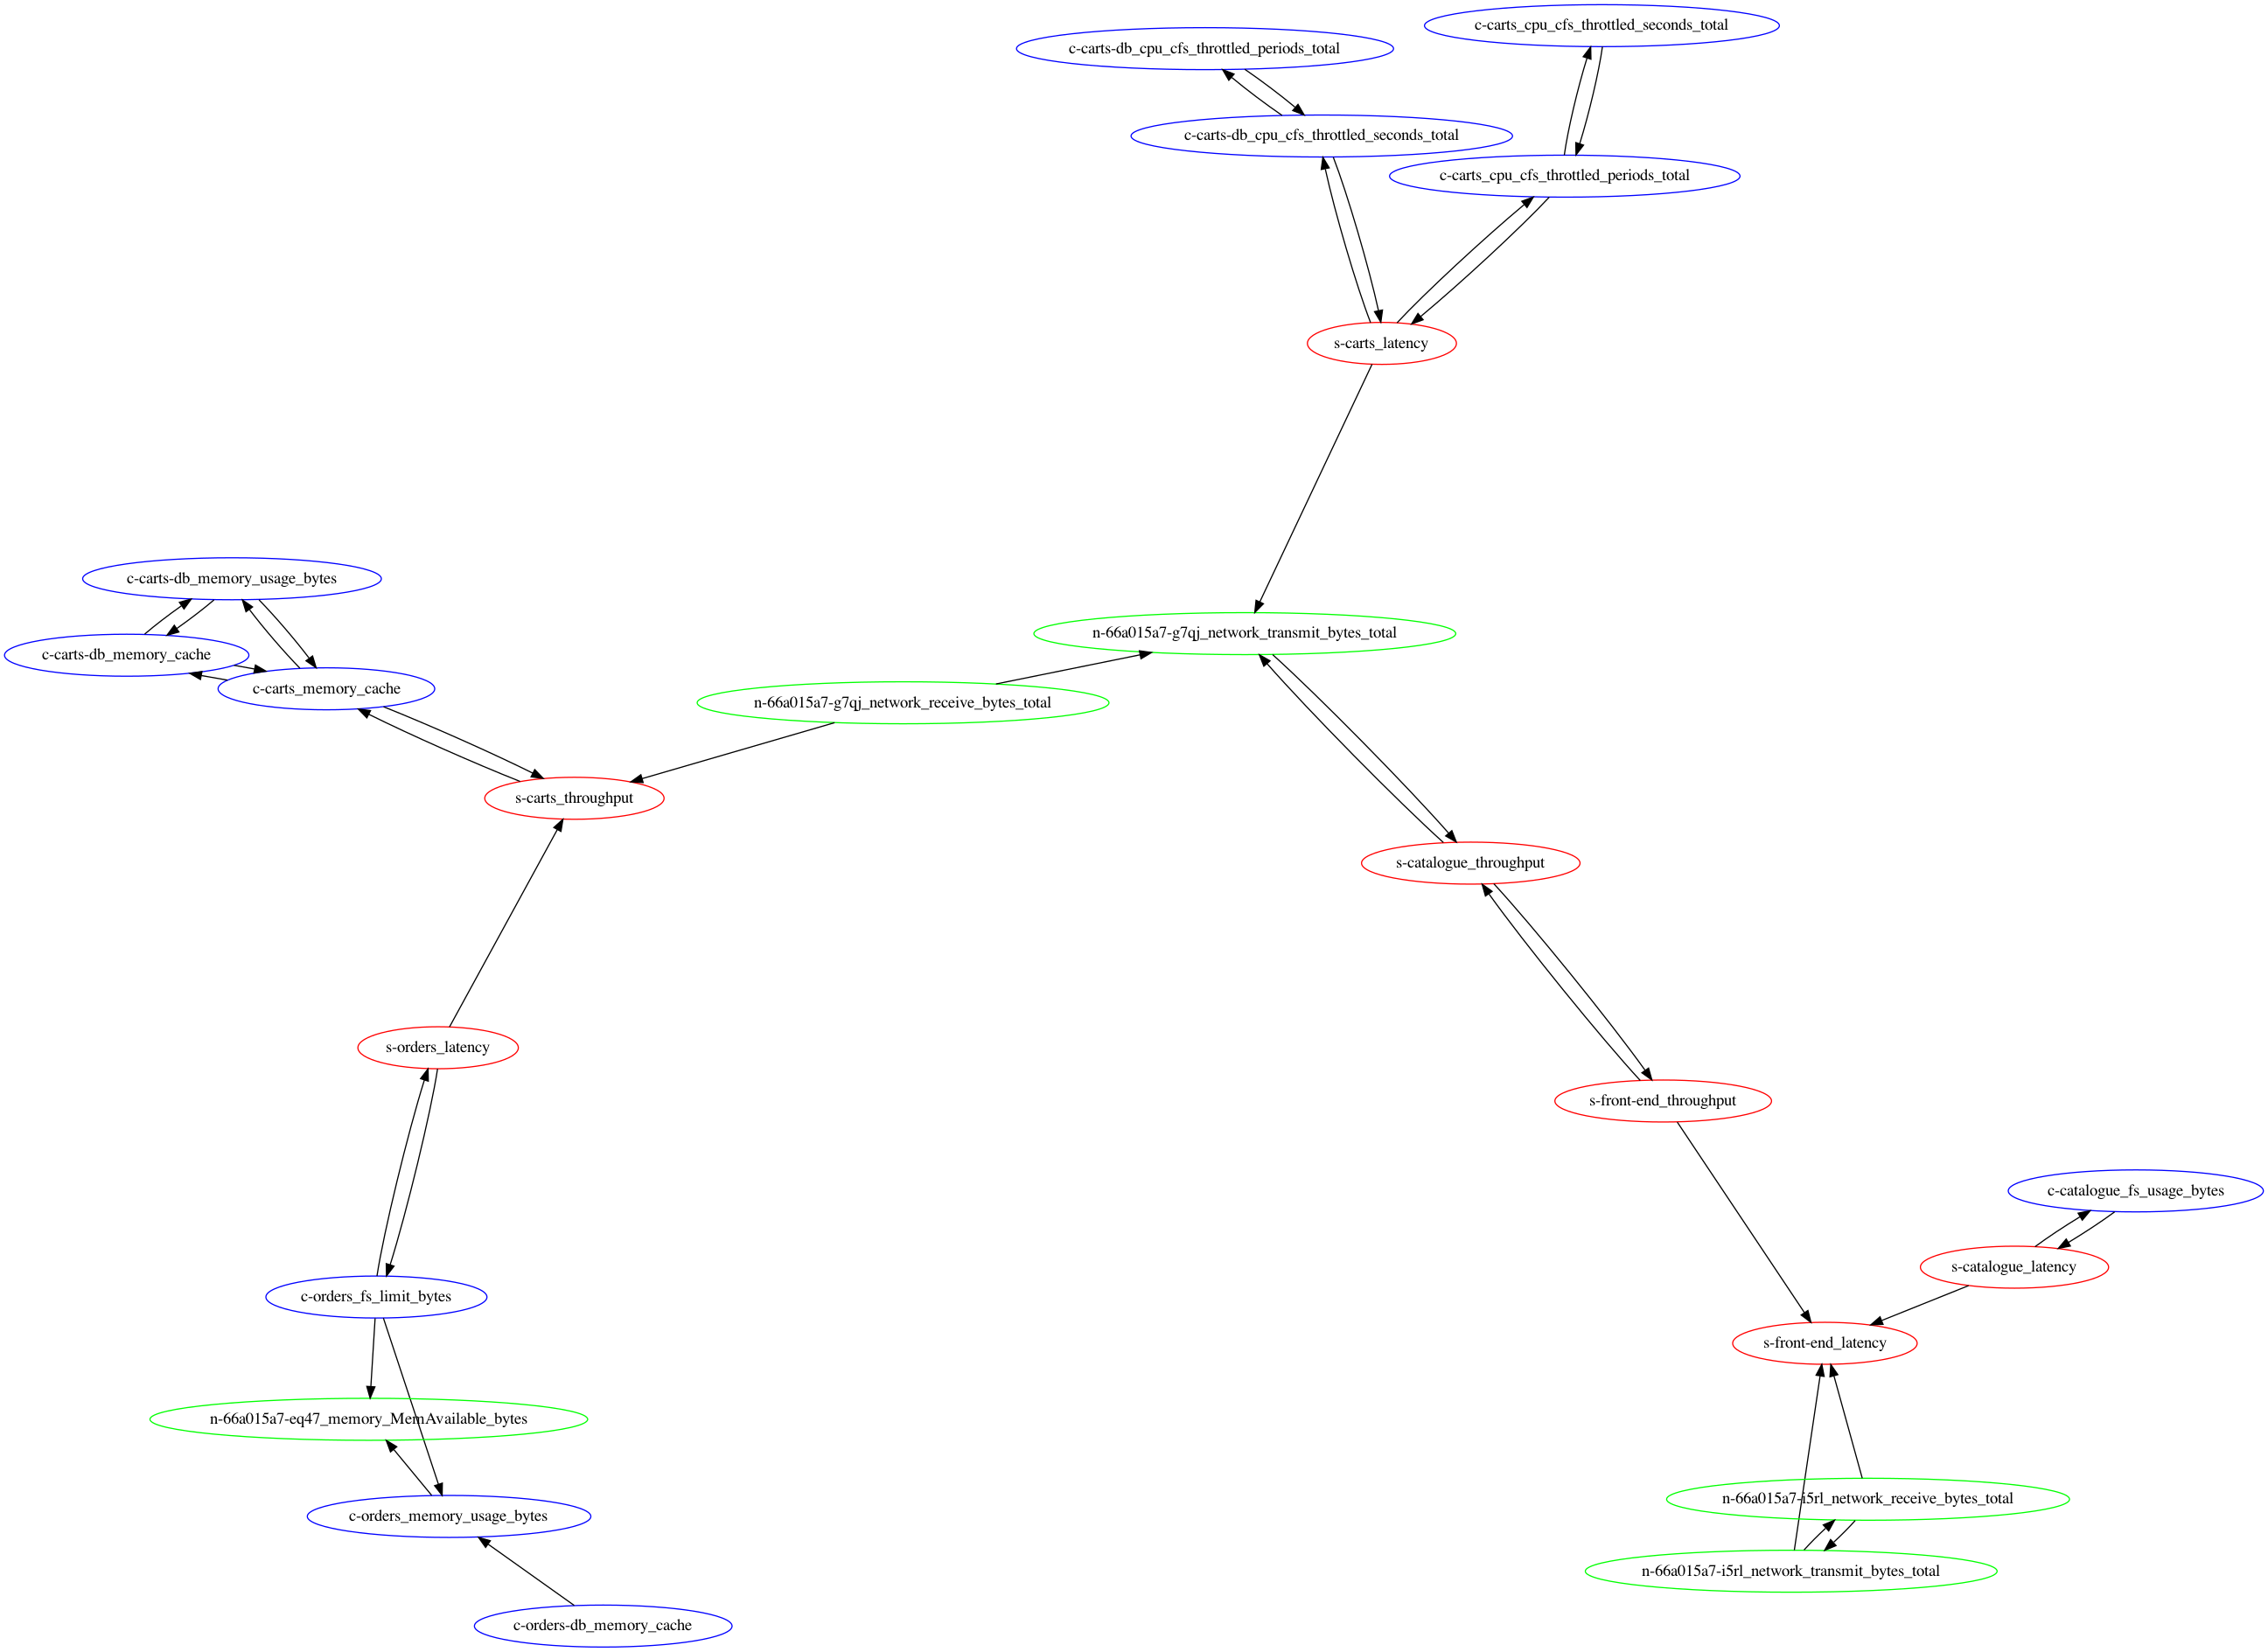

In [66]:
# Prepare init graph
dm = reduced_df.values
print("Shape of data matrix: {}".format(dm.shape))
init_g = nx.Graph()
node_ids = range(len(reduced_df.columns))
init_g.add_nodes_from(node_ids)
for (i, j) in combinations(node_ids, 2):
    init_g.add_edge(i, j)
print("Number of edges in complete graph : {}".format(init_g.number_of_edges()))
for no_path in no_paths:
    init_g.remove_edge(no_path[0], no_path[1])
print("Number of edges in init graph : {}".format(init_g.number_of_edges()))

# PC algorithm with Fisher-Z test
start = time.time()
cm = np.corrcoef(dm.T)
(G, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_fisher_z,
                                 data_matrix=dm,
                                 alpha=SIGNIFICANCE_LEVEL,
                                 corr_matrix=cm,
                                 init_graph=init_g)
G = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")

G = nx.relabel_nodes(G, labels)

# Exclude nodes that have no path to "s-front-end_latency" for visualization
remove_nodes = []
undirected_G = G.to_undirected()
for node in G.nodes():
    if not nx.has_path(undirected_G, node, "s-front-end_latency"):
        remove_nodes.append(node)
        continue
    if re.match("^s-", node):
        color = "red"
    elif re.match("^c-", node):
        color = "blue"
    elif re.match("^m-", node):
        color = "purple"
    else:
        color = "green"
    G.nodes[node]["color"] = color
G.remove_nodes_from(remove_nodes)
print("Number of nodes: {}".format(G.number_of_nodes()))

from IPython.display import Image, SVG, display

agraph = nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='png')
Image(agraph)

In [57]:
raw_data

,meta,mappings,containers,middlewares,nodes,services
prometheus_url,http://prometheus01.prv,NaN,NaN,NaN,NaN,NaN
grafana_url,http://grafana01.prv,NaN,NaN,NaN,NaN,NaN
grafana_dashboard_url,http://grafana01.prv/d/3cHU4RSMk/sock-shop-per...,NaN,NaN,NaN,NaN,NaN
start,1598415690,NaN,NaN,NaN,NaN,NaN
end,1598419290,NaN,NaN,NaN,NaN,NaN
step,15,NaN,NaN,NaN,NaN,NaN
count,"{'sum': 2463, 'containers': 754, 'middlewares'...",NaN,NaN,NaN,NaN,NaN
nodes-containers,NaN,{'gke-microservices-experi-default-pool-66a015...,NaN,NaN,NaN,NaN
orders,NaN,NaN,"[{'container_name': 'orders', 'metric_name': '...",NaN,NaN,"[{'service_name': 'orders', 'metric_name': 'th..."
payment,NaN,NaN,"[{'container_name': 'payment', 'metric_name': ...",NaN,NaN,"[{'service_name': 'payment', 'metric_name': 't..."


In [49]:
labels

{0: 'c-orders-db_fs_writes_total',
 1: 'c-orders-db_memory_cache',
 2: 'c-orders-db_cpu_user_seconds_total',
 3: 'c-orders-db_cpu_cfs_periods_total',
 4: 'c-orders-db_cpu_cfs_throttled_seconds_total',
 5: 'c-orders-db_fs_writes_bytes_total',
 6: 'c-orders-db_network_receive_packets_total',
 7: 'c-orders-db_memory_usage_bytes',
 8: 'c-orders-db_memory_rss',
 9: 'c-orders-db_memory_failures_total',
 10: 'c-orders-db_fs_reads_bytes_total',
 11: 'c-orders-db_cpu_system_seconds_total',
 12: 'c-queue-master_network_transmit_packets_total',
 13: 'c-queue-master_fs_usage_bytes',
 14: 'c-queue-master_cpu_cfs_periods_total',
 15: 'c-queue-master_memory_failures_total',
 16: 'c-queue-master_cpu_usage_seconds_total',
 17: 'c-queue-master_cpu_system_seconds_total',
 18: 'c-session-db_network_receive_bytes_total',
 19: 'c-shipping_fs_usage_bytes',
 20: 'c-shipping_cpu_user_seconds_total',
 21: 'c-shipping_cpu_cfs_periods_total',
 22: 'c-shipping_cpu_cfs_throttled_periods_total',
 23: 'c-shipping_net

## 可視化

In [19]:
# 正規化
normalized_df = pd.DataFrame()
for column in data_df.columns:
    data = data_df[column].values
    mean = data.mean()
    if mean == 0. :
        continue    
    normalized_df[column] = data_df[column] / data.mean()
normalized_df

,c-catalogue_spec_cpu_shares,c-catalogue_network_transmit_packets_total,c-catalogue_last_seen,c-catalogue_fs_inodes_total,c-catalogue_fs_usage_bytes,c-catalogue_spec_memory_limit_bytes,c-catalogue_cpu_cfs_periods_total,c-catalogue_network_transmit_bytes_total,c-catalogue_fs_limit_bytes,c-catalogue_memory_working_set_bytes,...,n-66a015a7-w0i8_network_receive_bytes_total,n-66a015a7-w0i8_network_transmit_bytes_total,n-66a015a7-w0i8_cpu_seconds_total,n-66a015a7-w0i8_filesystem_avail_bytes,n-66a015a7-w0i8_memory_MemAvailable_bytes,n-66a015a7-eq47_network_receive_bytes_total,n-66a015a7-eq47_network_transmit_bytes_total,n-66a015a7-eq47_cpu_seconds_total,n-66a015a7-eq47_filesystem_avail_bytes,n-66a015a7-eq47_memory_MemAvailable_bytes
0,1.0,0.962407,0.999999,1.0,0.920183,1.0,1.018163,1.008445,1.0,0.998809,...,0.988704,0.974659,0.998789,1.000071,0.999779,0.976505,0.973571,1.000197,1.000067,1.000822
1,1.0,0.983808,0.999999,1.0,0.920183,1.0,0.806640,1.012578,1.0,0.998809,...,0.996715,0.987998,1.000004,1.000069,0.997798,0.974619,0.973200,0.999892,1.000060,0.999738
2,1.0,0.814449,0.999999,1.0,0.920183,1.0,1.007740,0.840379,1.0,0.998809,...,0.994636,0.987314,0.998485,1.000067,1.000446,0.952954,0.949572,0.999842,1.000055,1.000848
3,1.0,0.942585,0.999999,1.0,0.926540,1.0,1.013604,0.978539,1.0,0.998809,...,0.994141,0.989174,0.999953,1.000066,0.999818,0.960059,0.959004,0.999283,1.000049,0.999648
4,1.0,0.959588,0.999999,1.0,0.926540,1.0,1.020121,1.002047,1.0,0.998809,...,0.993490,0.984363,0.999244,1.000064,1.000708,0.948256,0.945176,0.999537,1.000044,0.999464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,1.979255,1.000001,1.0,1.076195,1.0,1.024541,1.609279,1.0,1.036103,...,1.611083,1.650684,1.003850,1.000128,0.993653,1.537326,1.537345,1.000959,1.000004,0.998289
236,1.0,1.985361,1.000001,1.0,1.076195,1.0,1.028735,1.605277,1.0,1.036103,...,1.541036,1.583286,1.004002,1.000124,0.993354,1.535941,1.530833,1.000502,0.999995,0.998072
237,1.0,1.953490,1.000001,1.0,1.076195,1.0,1.015135,1.582513,1.0,1.036472,...,1.531434,1.563767,1.004103,1.000119,0.994038,1.507867,1.501413,0.999029,0.999986,0.998948
238,1.0,2.031666,1.000001,1.0,1.076195,1.0,1.014268,1.571701,1.0,1.038688,...,1.609310,1.648099,1.005419,1.000114,0.993696,1.520716,1.519261,0.999842,0.999977,0.998280


In [ ]:
test_df = 

<AxesSubplot:>

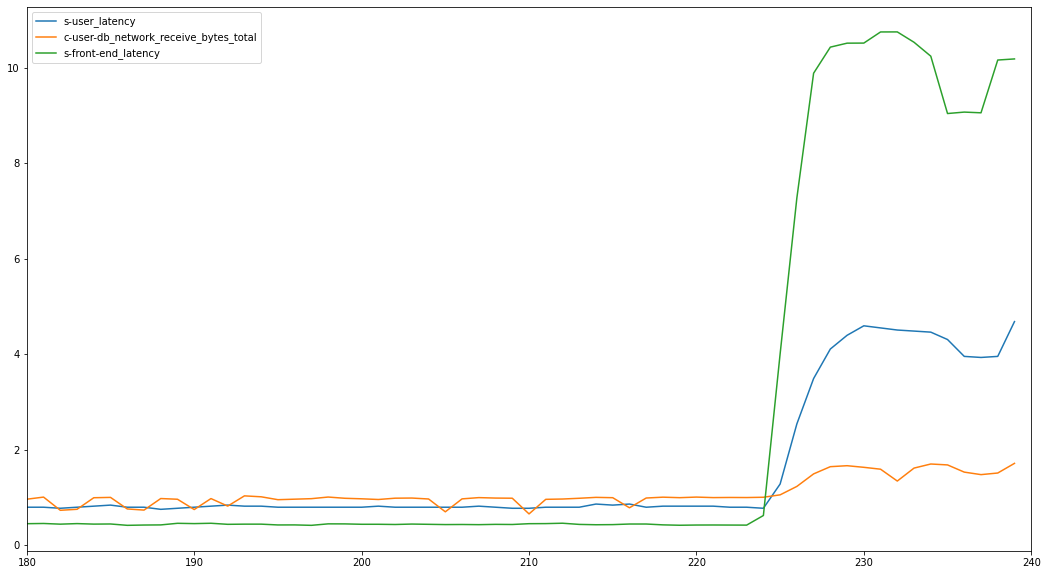

In [10]:
#r: -0.36374143835629597, s: ["n-66a015a7-w0i8_network_transmit_bytes_total"]
#r: -0.4527072447847273, s: [""]
#r: -0.5448722966478311, s: ["n-66a015a7-w0i8_memory_MemAvailable_bytes"]

df = pd.DataFrame()
mets = ["s-user_latency", "c-user-db_network_receive_bytes_total", "s-front-end_latency"]#, "s-orders_latency"]#, "n-66a015a7-w0i8_network_receive_bytes_total"]
for m in mets:
    if m == "s-user_latency":
        df[m] = normalized_df[m]
        continue
    df[m] = normalized_df[m]
df.plot(figsize=(18, 10), xlim=[180,240])

In [16]:
cm = np.corrcoef(df.values.T)
ci_test_fisher_z(df, 0, 1, set(), corr_matrix=cm)

9.862568996848589e-27

In [23]:
df

,s-user_latency,c-user-db_network_receive_bytes_total,s-front-end_throughput
0,0.240437,1.058736,1.030031
1,0.248385,1.064723,1.019455
2,0.264282,0.879429,1.012384
3,0.258321,1.051693,1.025477
4,0.268256,1.074101,1.042031
...,...,...,...
235,4.073522,0.556834,0.655190
236,4.069548,0.708627,0.647490
237,4.067561,0.702991,0.638397
238,4.081470,0.480824,0.635565


In [17]:
cm

array([[ 1.        , -0.60133073, -0.98269195],
       [-0.60133073,  1.        ,  0.60361564],
       [-0.98269195,  0.60361564,  1.        ]])

In [23]:
reduced_df.loc[:, reduced_df.columns.str.startswith("c-user-db")]

,c-user-db_network_receive_bytes_total,c-user-db_cpu_system_seconds_total,c-user-db_memory_usage_bytes,c-user-db_cpu_user_seconds_total
0,50976.3997,0.0076,71450624.0,0.0145
1,51751.1899,0.0083,71450624.0,0.0159
2,51281.5185,0.0106,71450624.0,0.0198
3,50933.7357,0.0108,71454720.0,0.0204
4,50307.2338,0.0100,71454720.0,0.0194
...,...,...,...,...
235,86466.3892,0.0173,74264576.0,0.0263
236,78706.7418,0.0161,74412032.0,0.0243
237,76008.1147,0.0164,74412032.0,0.0248
238,77735.8691,0.0124,74412032.0,0.0192


In [355]:
data = data_df["c-user-db_network_transmit_bytes_total"].values
mean = data.mean()
std = data.std()
if mean == 0. and std == 0.:
    cv = 0
else:
    cv = std / mean
cv

0.13629896604506445

In [81]:
r = 0.14
s = []
n = 240

from scipy.stats import norm
def log_q1pm(r):
    if r == 1:
        r = 1 - 1e-10
    return np.log1p(2 * r / (1 - r))
z = np.sqrt(n - len(s) - 3) * 0.5 * log_q1pm(r)
p_val = 2.0 * norm.sf(np.absolute(z))
print(z)
print(p_val)

2.1695216670546835
0.030043101214696118


In [5]:
dm.shape

(240, 126)

In [30]:
a = np.sqrt(240 - 1 - 3) * 0.5
a

7.681145747868608

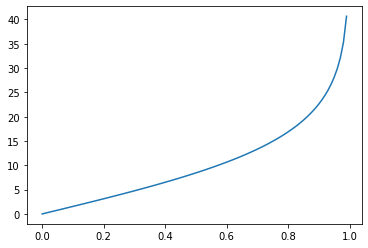

In [48]:
x = np.arange(0, 1, 0.01)
z = []
for xx in x:
    z.append(a * log_q1pm(xx))
plt.plot(x, z)

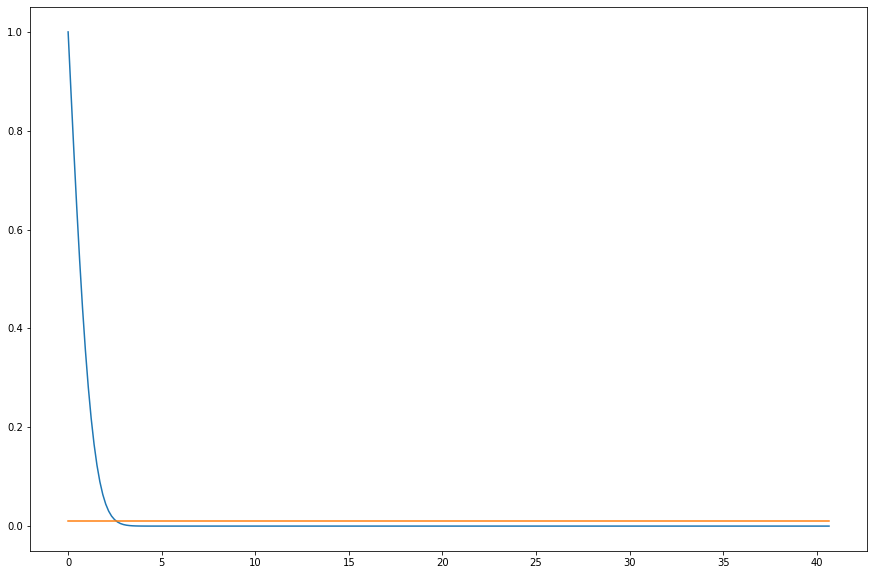

In [49]:
p_val = []
for zz in z:
    p_val.append(2.0 * norm.sf(np.absolute(zz)))
    
plt.figure(figsize=(15, 10))
plt.plot(z, p_val)
plt.plot(z, [0.01 for i in range(len(z))])

In [35]:
a

7.681145747868608

In [19]:
# partial correlation coefficient
r_xy = 0.6
r_xz = 0.9
r_yz = 0.6
def corr(r_xy, r_xz, r_yz):
    a = r_xy - (r_xz * r_yz)
    b = np.sqrt(1 - r_xz * r_xz) * np.sqrt(1 - r_yz * r_yz)
    return a/b

In [39]:
corr(-0.60, -0.91269195, 0.60361564)

-0.15065707805915243

In [ ]:
array([[ 1.        , -0.60133073, -0.98269195],
       [-0.60133073,  1.        ,  0.60361564],
       [-0.98269195,  0.60361564,  1.        ]])

In [17]:
x = np.arange(0,1,0.1)
y = np.arange(0,1,0.1)
xy = []
for xx in x:
    for yy in y:
        xy.append((xx, yy))

In [21]:
for i in xy:
    print(corr(-0.6, i[0], i[1]))

-0.6
-0.6030226891555273
-0.6123724356957946
-0.628970902033151
-0.6546536707079771
-0.6928203230275509
-0.75
-0.8401680504168059
-1.0000000000000002
-1.3764944032233708
-0.6030226891555273
-0.6161616161616161
-0.6359727033932191
-0.6637465183030646
-0.7018151412904203
-0.7543365091413574
-0.8291561975888501
-0.9429140723896728
-1.1390428572937739
-1.5909432668919719
-0.6123724356957946
-0.6359727033932191
-0.6666666666666667
-0.7061348126430064
-0.7572401854185358
-0.8249579113843055
-0.9185586535436918
-1.0575746083788047
-1.2927862531355665
-1.8263423325843036
-0.628970902033151
-0.6637465183030646
-0.7061348126430064
-0.7582417582417582
-0.8235162195690195
-0.9078412990032037
-1.0220777158038705
-1.1889928271927077
-1.467598771410686
-2.0922894055608863
-0.6546536707079771
-0.7018151412904203
-0.7572401854185358
-0.8235162195690195
-0.9047619047619048
-1.0079052613579393
-1.1456439237389604
-1.34449112897471
-1.6730038251426087
-2.4030056367444432
-0.6928203230275509
-0.75433650914